In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

<Axes: >

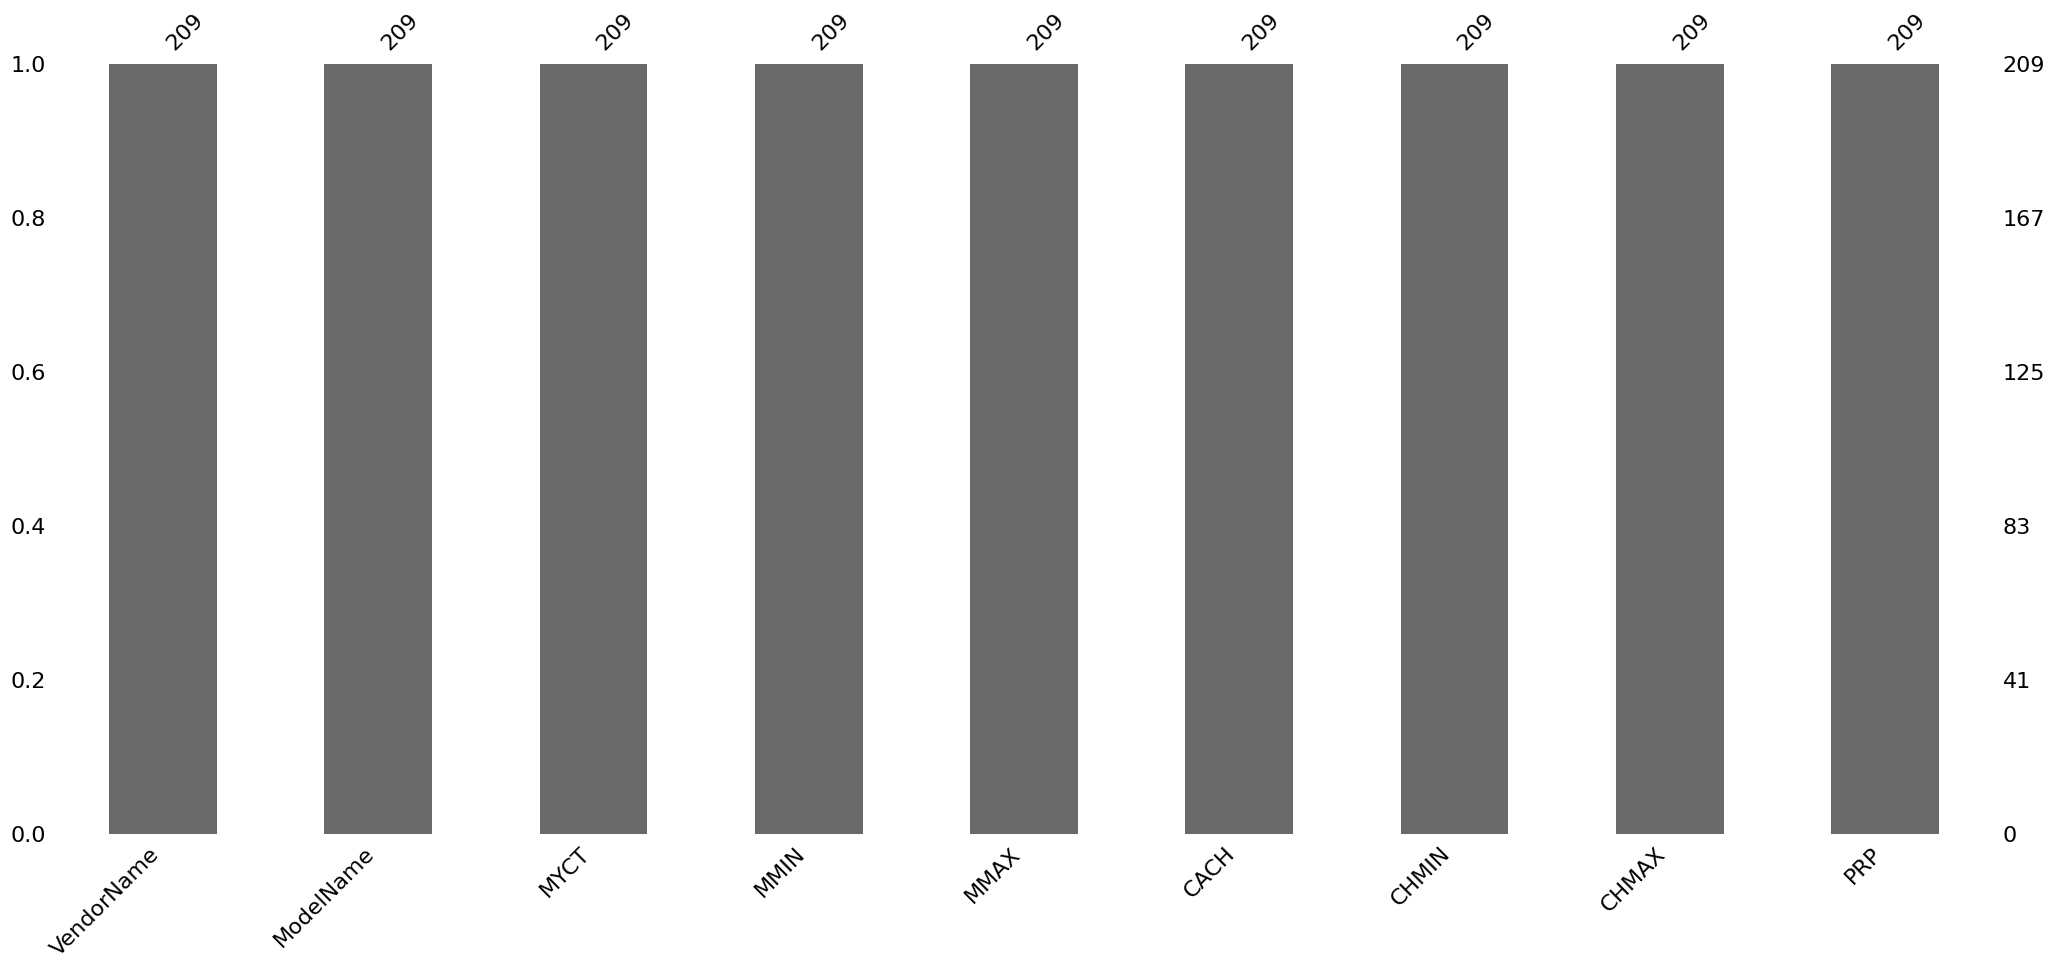

In [2]:
## csv로 저장되어 있는 값을 pandas의 DataFrame 값으로 변환 하기
machine = pd.read_csv("machine_data.csv")
## 컬럼이 무엇이 있는지 확인
machine.columns
import missingno as msn
# 결측값의 개수를 막대 그래프로 시각화 한다.
msn.bar(machine)

In [3]:
# 정확성을 위해서 결측치의 값을 제거해 준다
# 결측치가 하나도 없는 것을 알 수 있다.
machine.dropna(inplace = True)
#결측치가 없는 것을 확인했기 때문에 PRP와의 상관 관계를 계산해서 변수를 선택해줘야한다.
# pandas 라이브러리에 포함된 DataFrame의 메서드인 corr() 메서드를 사용해야 한다.
# 또한 상관도를 구할 때 모든 변수들의 값은 수치화 되어야 한다.
# 모든 변수를 수치화 한다.
dums = pd.get_dummies(machine, dtype=float)
# PRP와의 상관계수 계산
prp_resulte = dums.corr()['PRP']
# 상관계수 값을 절대값으로 변환
# 변환의 이유는 간단하다. corr() 메서드가 -1~1의 값을 가져오기 때문이다.
prp_resulte= np.abs(prp_resulte)

In [4]:
# 상관계수를 내림차순으로 정렬
prp_resulte.sort_values(ascending=False)
# 내림차순으로 선택 후 상관 관계가 높은 features 선택
num_features = prp_resulte.sort_values(ascending=False).index[1:6].tolist()
X_train = dums[num_features]
X_test = dums[num_features]
y_train = dums['PRP']
y_test = dums['PRP']

In [5]:
# 앙상블 기법으로 모델 생성 및 학습  : LinearRegression, SGDRegressor, Ridge, GradientBoostingRegressor
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)])
# 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor()),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]
# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('ensemble', ensemble)])

# 하이퍼파라미터 튜닝
params_grid = {
    "ensemble__sgd__alpha": [0.0001, 0.1, 1.0],
    "ensemble__sgd__max_iter": [1000, 2000, 3000],
    "ensemble__ridge__alpha": [10, 20],
    "ensemble__gbr__n_estimators": [100, 200],
    "ensemble__gbr__learning_rate": [0.01, 0.1]
}
grid_search = GridSearchCV(model_pipeline, params_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MMAX',
                                                                          'MMIN',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor()),
                                                                    ('ridge',
                                                                     Ridge(random_state=42)),
                                                                    ('gbr',
                                                                     GradientBoostingRegressor(random_state=42))]))]),
             param_grid={'ensemble__gbr__learning_rate': [0.01, 0.1],
                         'ensemble__gbr__n_estimators': [100, 200],
                         'ensemble__ridge__alpha': [10, 20],
                         'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             return_train_score=True, scoring='neg_mean_squared_error')

Mean Squared Error: 2154.485391293727
Mean Absolute Error: 29.704648579607724
R^2 Score: 0.9163071375540699


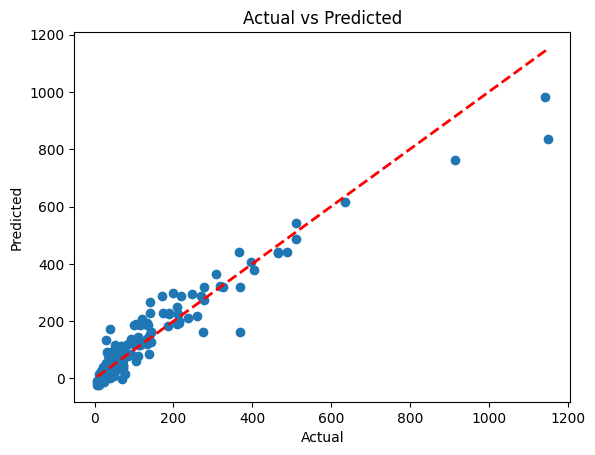

In [8]:
# 최적 파라미터를 이용하여 최적 모델로 예측하기
# 1) 최적 파라미터 출력
# print(f'Best parameters: {grid_search.best_params_}')

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 2) 최적 모델 출력
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# 최적 모델 성능 평가 및 시각화
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [7]:
# GridSearchCV 결과 분석
result = pd.DataFrame(grid_search.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ensemble__gbr__learning_rate,param_ensemble__gbr__n_estimators,param_ensemble__ridge__alpha,param_ensemble__sgd__alpha,param_ensemble__sgd__max_iter,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068807,0.019539,0.003199,4.003070e-04,0.01,100,10,0.0001,1000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6495.277342,7575.243922,63,-2282.812722,-3334.245564,-3423.581827,-3237.087288,-1706.007085,-2796.746897,682.578667
1,0.054005,0.000633,0.003000,4.101908e-07,0.01,100,10,0.0001,2000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6500.597241,7581.022518,65,-2295.209921,-3342.617017,-3414.228238,-3242.286069,-1707.775385,-2800.423326,680.454739
2,0.067205,0.016192,0.004002,8.946829e-04,0.01,100,10,0.0001,3000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6499.016551,7604.213005,64,-2289.221585,-3344.954514,-3426.839303,-3244.835103,-1713.529201,-2803.875941,682.498275
3,0.055204,0.001940,0.003001,5.206049e-06,0.01,100,10,0.1000,1000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6475.638043,7568.433264,56,-2331.102870,-3377.148646,-3479.427073,-3292.367064,-1739.692472,-2843.947625,688.709901
4,0.054009,0.000596,0.003002,5.854815e-06,0.01,100,10,0.1000,2000,"{'ensemble__gbr__learning_rate': 0.01, 'ensemb...",...,-6469.267926,7568.513557,55,-2319.414091,-3387.096880,-3496.129742,-3293.641179,-1735.111533,-2846.278685,696.735625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.110212,0.012226,0.003201,3.996659e-04,0.10,200,20,0.1000,2000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5705.661314,6488.599690,1,-1639.533074,-2411.045781,-2485.402207,-2330.900451,-1194.021026,-2012.180508,508.500882
68,0.101408,0.001021,0.003000,5.539526e-06,0.10,200,20,0.1000,3000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5726.308317,6526.972593,4,-1640.470961,-2410.658038,-2486.249758,-2330.502084,-1194.067660,-2012.389700,508.395716
69,0.103608,0.002153,0.003002,6.022889e-06,0.10,200,20,1.0000,1000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5756.456037,6687.778951,19,-1766.081754,-2595.917407,-2679.801767,-2493.673907,-1292.215449,-2165.538057,543.989779
70,0.104608,0.007762,0.003003,3.743703e-06,0.10,200,20,1.0000,2000,"{'ensemble__gbr__learning_rate': 0.1, 'ensembl...",...,-5749.407727,6674.205777,13,-1766.940762,-2577.207163,-2691.304033,-2470.003034,-1293.677692,-2159.826537,539.899515
